# Milestone 2

    As we started to work on this part of our project we already knew we wished to write an aleatoric composition. So we started to consider what we wanted to be aleatoric and soon we decided to create an aleatoric note and rhythm generator.

    In order to put those two ideas into place we created classes and functions that would help us along the way. We computed a class to create scales based on certain information such as the note on which the scale is based and the type of scale such as minor, major, etc. It is also possible to generate a random scale using this class’ constructor. This class would then help us to generate a random sequence of notes found in a specific scale. In Vivaldi’s four seasons, each movement is based on a certain scale which will also be at the base of our interpretation of this piece. Furthermore we decided to create a class to generate chords based on a given note and scale. This will help us construct a stronger base for our piece.

    We also decided to generate a random rhythm to accompany our random sequence of notes. To achieve that we decided to compute a code inspired by the Markov tree but by interpreting and changing it according to what was more intuitive to us. The functions we wrote would generate a sequence of random numbers and transform those in note durations and rests according to some conditions carefully chosen by us.
    We then decided to put melody, rhythms and chords together and add functions/rules in order to end up with a partition that makes sense. For example one rule prevents the piece to start with a rest. Another rule would make sure that the rhythm is "clean". This means that we will never have a note overlapping from one bar to the next.

    Furthermore to give more sense to our seasons we have decided that in the end we would add some audio files representing each season. For example, for the spring we will be adding sounds of singing birds. Those audio files are taken from Youtube and the background noises are deleted by modifying the audio file using Audacity. It is even possible to change the pitch of these files. This technique will very likely be explored more once we will assemble the score and the audio files to see if the pitch of the audio can be adjusted to the scale of the piece. 

    We are well aware that our code could have been shorter as some functions or examples will not be used in the final generation of our code. However we decided to keep these functions and examples as they help us understand and assess different outcomes. For example all the displays of the name of the notes, chords or scales is not necessary for the generation of the final score but it is useful in the understanding of the code. Another aspect of our code that we will have to review is the guitar as it does not seem to add information to our piece. We might be trying out other rhythms for the guitar. In the previous milestone we also mentioned that we will be using percussion throughout the four seasons. As of right now we have not generated the rhythm for this. We will however try to incorporate it in future steps. 


# Imports

In [1]:
import random                  
from fractions import Fraction   
import functools
import math
import numpy as np
import matplotlib.pyplot as plt
from music21 import chord, corpus, environment, meter, midi, note, stream, tempo, dynamics, instrument, key, duration
from IPython.display import Audio
import time
random.seed(time.time())

### MuseScore3 Windows
##### Run the following cell if you are using this file on a Windows

In [ ]:
# Windows (adapt Program Files)
musescore_executable = r'C:\Program Files\MuseScore 3\bin\MuseScore3.exe'

environment.set('musescoreDirectPNGPath', musescore_executable)
environment.set('musicxmlPath', musescore_executable)
environment.set('autoDownload', 'allow')

### MuseScore3 Mac
##### Run the following cell if you are using this file on a Mac

In [2]:
# Mac path
musescore_executable = '/Applications/MuseScore 3.app/Contents/MacOS/mscore'

environment.set('musescoreDirectPNGPath', musescore_executable)
environment.set('musicxmlPath', musescore_executable)
environment.set('autoDownload', 'allow')

# Tools

## Music Tools
##### The following functions will be used in the code.

In [3]:
# function to return key for any value - This function will be used in the class chord
def getKeyFromValue(_dictionnary, _value):
    for key, value in _dictionnary.items():
         if _value == value:
             return key
 
    return None; #doesn't exist

#Shortcut to play a stream
def play(score):
    midi.realtime.StreamPlayer(score).play();
    
#This function takes two notes and checks whether they represent the same note without looking at the octave. It returns true if they represent the same note and false otherwise
def isSameNoteWithoutOctave(note1, note2):
    
    if note1.pitch.name == note2.pitch.name: 
        return True;
    
    # To lose the octave information
    n1 = note.Note(pitch = note1.pitch.name);
    n2 = note.Note(pitch = note2.pitch.name);
    
    if n1.pitch.frequency == n2.pitch.frequency:
        return True;
    
    return False;

##### Example using the function *isSameNoteWithoutOctave()*

In [4]:
d = note.Note("D#3");
e = note.Note("Eb5");

print(isSameNoteWithoutOctave(d,e));

True


## Math Tools

In [5]:
def gaussParameter(x, doubleSigma, mu): # with value 1 at x = mu
    sigma = doubleSigma/2;
    return math.exp(-1/2*(x-mu)**2/sigma**2); #1/sigma/math.sqrt(2*math.pi)*

def gaussFunction(doubleSigma, mu = 0):
    return functools.partial(gaussParameter, mu = mu, doubleSigma = doubleSigma);

def intervalParameter(x, a):
    if x >= -a and x <= a:
        return 1;
    return 0;

def intervalFunction(a):
    return functools.partial(intervalParameter, a=a)

##### Example using the interval function and the gauss function. We apply the functions to 100 values of x ranging from -20 to 20. The interval between each value for x is equal. Then we plot the graphs corresponding to each function.

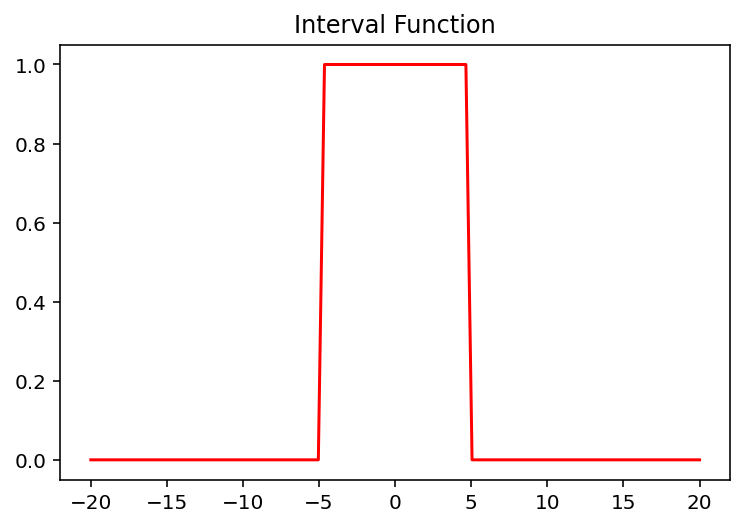

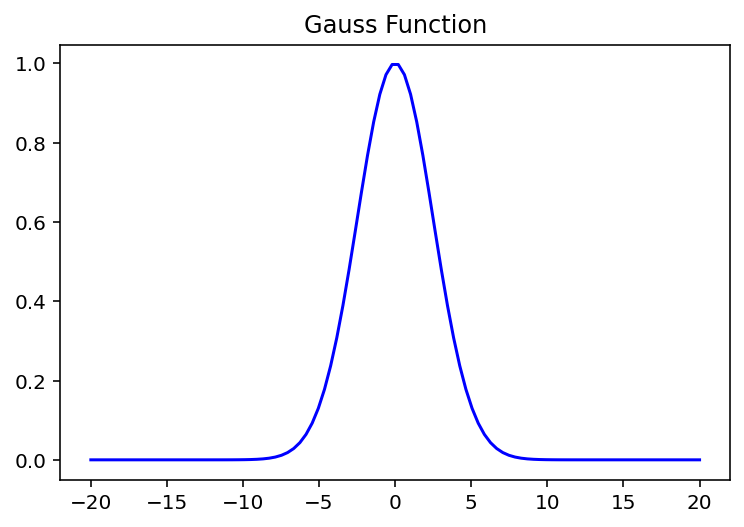

In [6]:
x = np.linspace(-20,20,100);
y = np.zeros(len(x));


f = intervalFunction(5);

for i in range(len(x)):
    y[i] = f(x[i]);

plt.plot(x,y, 'r');
plt.title('Interval Function')
plt.show();


f = gaussFunction(5);

for i in range(len(x)):
    y[i] = f(x[i]);

plt.plot(x,y, 'b');
plt.title('Gauss Function')
plt.show();

# Scale

### Scales interval dictionnary
##### Scales interval dictionnary links the name of the scale and the amount of numbers between each note starting from the base note

In [7]:
scalesIntervalDictionnary = {
  "major": [0,2,4,5,7,9,11],
  "minor": [0,2,3,5,7,8,10]
}

### Scale class
##### Scale is a class generating a musical scale / a range starting from the base note and the type of scale (major, minor, dorian or else). It can also generate a scale from a random base and random type.

In [8]:
class Scale:
    
    # Constructor
    def __init__(self, _baseNote = note.Note('C4'), _interval = scalesIntervalDictionnary["major"], _randomBase = False, _randomMinorMajorScale = False):
              
        if _randomBase == True:
            self.baseNote = note.Note(pitch = random.randint(0,11));
        else: 
            self.baseNote = _baseNote;
             
        if _randomMinorMajorScale == True:
            r = random.randint(0,1);
            if r == 1:
                self.interval = scalesIntervalDictionnary["major"];
            else:
                self.interval = scalesIntervalDictionnary["minor"];
        else:
            self.interval = _interval;
    
    # Gets the ith tone of the scale, i = 1 returns the fundamental, i = 2 returns the "seconde"
    def getTone(self, i):
        return self.baseNote.transpose(self.interval[(i-1)%len(self.interval)]);
    
    # Get notes of the scale without considering the octave
    def getNotesWithoutOctave(self):       
        n = [self.baseNote.transpose(i) for i in self.interval];
        return n;
    
    # is the given ton on the scale
    def isToneOnScale(self, note):
        for i in range(len(self.interval)):
            if isSameNoteWithoutOctave(self.baseNote.transpose(self.interval[i]), note):
                return True;
        return False;
    
    # is Minor if the third minor is on the scale
    def isMinor(self):
        return self.isToneOnScale(self.baseNote.transpose(3));
    
    # is Major if the third major is on the scale
    def isMajor(self):
        return self.isToneOnScale(self.baseNote.transpose(4));
    
    
    # show is a function that shows all the notes of the scale.
    def show(self):   
        text = self.baseNote.pitch.name;
        if self.isMajor():
            text += " major";
        if self.isMinor():
            text += " minor";
        print(text, self.interval);  
        
        m = stream.Measure();
        m.append([self.baseNote.transpose(i) for i in self.interval]);     
        m.append(self.baseNote.transpose(12));
        m.show();
        
  

### Example of a scale
##### In this example we construct a scale 's' base on the note 'C' and the type 'major'. We get the third tone of the scale by calling the function getTone and show it. It is the first outcome visible. Then we want to check that the scale constructed is a major scale like we intended to. So we call the isMinor function to make sure it is not a minor scale. In our piece we only have minor and major scales and therefore if it isn't minor it is major. And as we can see in the outcome it is indeed not a minor sclae as the function isMinor returns false. We then want to show our scale by printing its name, its note intervals and the actual notes on the score.

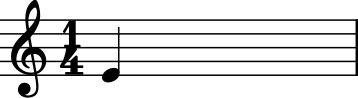

minor: False
C major [0, 2, 4, 5, 7, 9, 11]


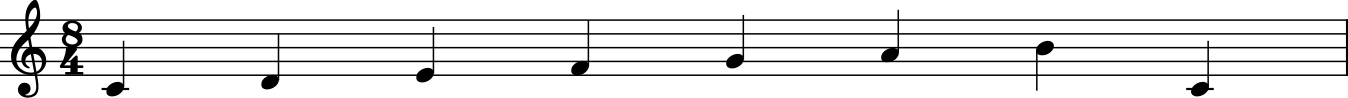

In [9]:
s = Scale(note.Note("C"), scalesIntervalDictionnary["major"]);
s.getTone(3).show() # la tierce
print("minor:", s.isMinor())
s.show();

# Chord

### Chords type dictionnary

In [10]:
chordsDictionnary = {
  "": [0,4,7],
  "5": [0,7],
  "m": [0,3,7],
  "7": [0,4,7,10],
  "m7": [0,3,7,10]
}

### Chord Class
##### Chord is a class constructing a chord based on a base note and a scale

In [11]:
class Chord:
    
    # Constructor
    def __init__(self, _baseNote, _scale):

        self.baseNote = _baseNote;
        self.interval = [0]; # 1th and 5th
        
        if _scale.isToneOnScale(_baseNote.transpose(3)) == True:
            self.interval.append(3);
        elif _scale.isToneOnScale(_baseNote.transpose(4)) == True:           
            self.interval.append(4);
            
        self.interval.append(7);
        
    def copy(self):
        b = note.Note(pitch = self.baseNote.pitch.name);
        c = Chord(b, Scale());
        c.interval = self.interval;
        return c;
                
    # Define (like a constructor)
    def defineByType(self, _baseNote, _type = ""):       
        self.baseNote = _baseNote;
        self.interval = chordsDictionnary[_type];
            
            
    def getType(self):
        key = getKeyFromValue(chordsDictionnary, self.interval);
        if key != None:
            return key;
        return "Not in dictionnary";    
    
    def getName(self):
        return self.baseNote.name + self.getType();
    
    # Get notes
    def getNotesWithoutOctave(self):       
        n = [self.baseNote.transpose(i) for i in self.interval];
        return n;    
    
    def getNotesWithOctave(self, _octave = 4, _quarterLength = 1):       
        n = [note.Note(pitch = self.baseNote.transpose(i).pitch.name, octave = _octave, quarterLength = _quarterLength) for i in self.interval];
        return n;    
    
    def getChordObject(self,  _octave = 4, _quarterLength = 1):
        return chord.Chord(self.getNotesWithOctave(_octave = _octave, _quarterLength = _quarterLength));
    
    # Show
    def show(self):
        self.getChordObject().show();
        
    def getText(self):
        return self.baseNote.pitch.name + " " + self.getType();
        
    def showText(self):
        print(self.getText());  

### Example of a chord construction 
##### The chord is constructed based on the note F and the scale s defined in the previous example (cf Example of a scale). To make sure our chord is correctly constructed we will print as many information about it as possible. First we show the chord on a score. We also print its name, the intervals betwen each note (4 means that there are 4 semitones between the first and second note of the chord and 7 means that there are 7 semitones between the first and third note of the chord). We also print the notes in music21.note.Note format. We can see in the results that the notes of the chord are F, A and C. To go even further, we wanted to show that there is a possibility to change the duration of our chord which is represented on the second score.

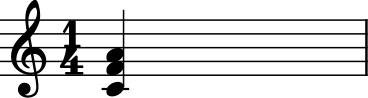

F
[0, 4, 7]
[<music21.note.Note F>, <music21.note.Note A>, <music21.note.Note C>]


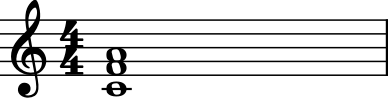

In [12]:
c = Chord(_baseNote = note.Note("F"), _scale = s);
c.show();
print(c.getName());
print(c.interval)
print(c.getNotesWithOctave())
c.getChordObject(_quarterLength = 4).show();

# NotesRange

### NotesRange Class

In [13]:
class NotesRange:
    
    # Constructor
    def __init__(self, _octaveNumber = 8):  
        
        self.range = {}; # Dictionnary
        for o in range(_octaveNumber):
            for i in range(0,12):
                n = note.Note(pitch = i);
                self.range[n.pitch.name + str(o)] = 0;   
        
        self.range["C" + str(o+1)] = 0; # highest C
                
                
    # Add chance/probability to notes (without octave) 
    # if _probability is empty, then all notes' probability will be increased by 1 
    def addChanceToNotesWithoutOctave(self, _notes = [], _probabilities = [], _probability = 1):
        
        if len(_notes) != 0 and len(_probabilities) < len(_notes):
            _probabilities = [_probability for i in _notes];
        
        for key in self.range:
            for x in range(len(_notes)):
                if isSameNoteWithoutOctave(note.Note(key), _notes[x]) == True:
                    self.range[key] += _probabilities[x];
        return;
    
    
    def multiplyChanceToNotesWithoutOctave(self, _notes = [], _probabilities = [], _probability = 1):
        
        if len(_notes) != 0 and len(_probabilities) < len(_notes):
            _probabilities = [_probability for i in _notes];
        
        for key in self.range:
            for x in range(len(_notes)):
                if isSameNoteWithoutOctave(note.Note(key), _notes[x]) == True:
                    self.range[key] *= _probabilities[x];
        return;
    
    
    # Mulitiply by a function. 0 is the _zeroNote and then +1 for the next note etc, 12 is the distance for an octave
    def multiplyByFunction(self, _function, _zeroNote = note.Note("C4")):              
        keysLength = len(self.range.keys());
        for key in self.range.keys():             
            x = note.Note(key).pitch.midi - _zeroNote.pitch.midi;                     
            #print(key + "  " + str(x) + " f(x): " + str(_function(x)))
            self.range[key] *= _function(x);   
            
    def pickRandomNote(self):
        totalProbability = 0;
        for key in self.range.keys(): 
            totalProbability += self.range[key];
        
        if totalProbability == 0:
            print("NotesRange.pickRandomNote() has no solution!");
            self.showPlot();
        
        r = random.uniform(0,totalProbability);
        #print(str(totalProbability) +"  " + str(r));
        
        counter = 0;
        for key in self.range.keys():
            counter += self.range[key];
            if counter >= r:
                return note.Note(key);          
        return None; # empty notesRange
    
    # Show 
    def show(self):
        print(self.getText());
        
    # Get Text for show()
    def getText(self):
        txt = "{ ";
        for key in self.range.keys():
            value = self.range[key];
            if value != 0:
                txt += key + ": " + str(value) + ", ";
                
        if txt == "{ ":
            return "{ empty NotesRange }";
        return txt[:-2] + " }";
        
    # Show Plot
    def showPlot(self):
        keys = self.range.keys();
        values = self.range.values();
        plt.bar(keys, values);

### Example for NotesRange class
##### In this example we first construct a NotesRange element (nr) and add probabilities to the notes C and D. We then create a function and multiply the probabilities using this function. In the plot you can see that a lot of notes have probability 0.This means that when generating a piece made from those notes, only the ones with a probability bigger than zero will be generated. The likelihood of them appearing will be proporitonate to their probability. 

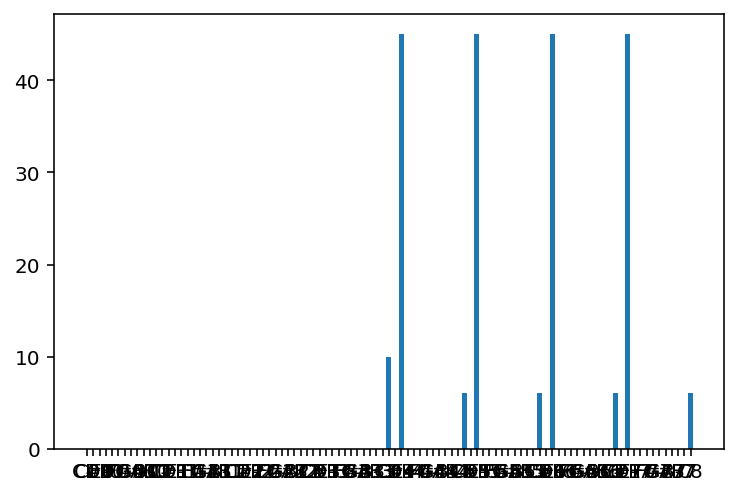

In [14]:
nr = NotesRange();

nr.addChanceToNotesWithoutOctave([note.Note("C"),note.Note("D")], [2,15]);

def ff(x): 
    if x < 0:
        return 0;
    if x == 0:
        return 5;
    return 3;


nr.multiplyByFunction(ff);
nr.showPlot();

### Example using scales, chords and notes range
##### First we generate a C major scale. Then we create a list of notes and chords to which we add the bass note (C). We then generate a notesRange with plenty of rules that will apply to the notes and chrods. Following that we create and display a score which shows the chords and notes we generated. As you can see from this score, the notes we generated are always found in its corresponding chord.

C major [0, 2, 4, 5, 7, 9, 11]


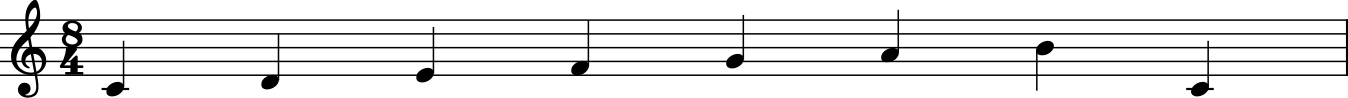


NotesRange:
0 { D2: 1, E2: 3, F2: 1, G2: 3, A2: 1 }
1 { C2: 1, D2: 3, E2: 1, F2: 1, A2: 1, C3: 1 }
2 { D2: 1, E2: 3, F2: 1, G2: 3, A2: 1 }
3 { C2: 1, D2: 1, F2: 1, G2: 3, A2: 1, C3: 1 }
4 { D2: 1, E2: 3, F2: 1, G2: 3, A2: 1 }
5 { C2: 1, D2: 3, E2: 1, F2: 1, A2: 1, C3: 1 }
6 { C2: 1, E2: 1, F2: 3, G2: 1, A2: 3, C3: 1 }
7 { C2: 1, D2: 3, E2: 1, F2: 1, A2: 1, C3: 1 }

Chords:
0 C  [<music21.note.Note C>, <music21.note.Note E>, <music21.note.Note G>]
1 G  [<music21.note.Note G>, <music21.note.Note B>, <music21.note.Note D>]
2 C  [<music21.note.Note C>, <music21.note.Note E>, <music21.note.Note G>]
3 E m [<music21.note.Note E>, <music21.note.Note G>, <music21.note.Note B>]
4 C  [<music21.note.Note C>, <music21.note.Note E>, <music21.note.Note G>]
5 G  [<music21.note.Note G>, <music21.note.Note B>, <music21.note.Note D>]
6 D m [<music21.note.Note D>, <music21.note.Note F>, <music21.note.Note A>]
7 G  [<music21.note.Note G>, <music21.note.Note B>, <music21.note.Note D>]


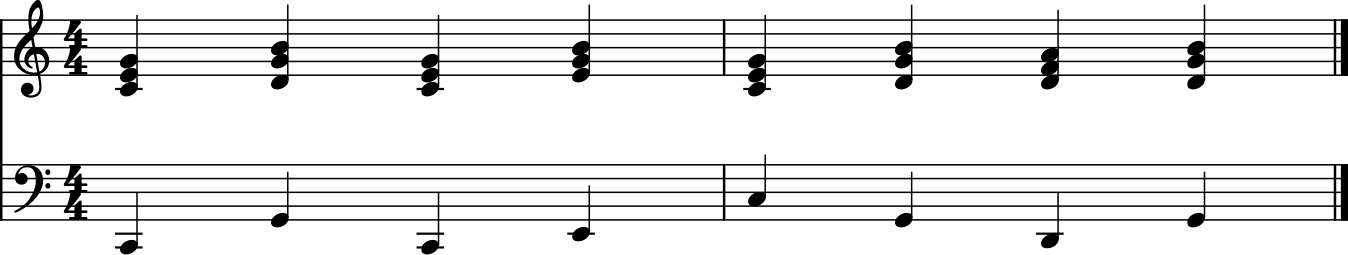

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


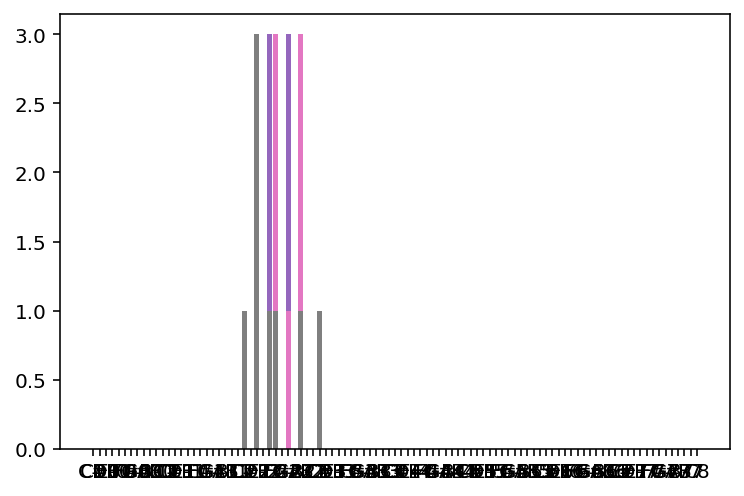

In [15]:
s = Scale(note.Note("C"), scalesIntervalDictionnary["major"]);
s.show();

# input
octaveRegion = 2;
nbr = 8;
bassNotes = [];  # stores music21's note.Note()
bassChords = []; # stores Chord objects

bassNotes.append(note.Note(pitch = s.baseNote.pitch.name, octave = octaveRegion)); # bassNotes[0]
bassChords.append(Chord(bassNotes[0], s));                                         # bassChords[0]

print("\nNotesRange:")
for i in range(nbr): 
    
    # Bass Rules
    nr = NotesRange();
    nr.addChanceToNotesWithoutOctave(s.getNotesWithoutOctave()); # notes of the scale
    
    if s.isMinor():
        nr.multiplyChanceToNotesWithoutOctave([s.getTone(2)], _probability = 0);
    if s.isMajor():
        nr.multiplyChanceToNotesWithoutOctave([s.getTone(7)], _probability = 0);
        
    nr.multiplyChanceToNotesWithoutOctave(bassChords[i].getNotesWithoutOctave(), _probability = 3); # notes of the chord from the bassNotes[i]
    nr.multiplyChanceToNotesWithoutOctave([bassNotes[i]], _probability = 0); # avoir playing the same bassNotes[i] again
    nr.multiplyByFunction(intervalFunction(6), note.Note(pitch = 6, octave = octaveRegion)); # range, to stay in the octaveRegion
    
    
    nr.showPlot();
    print(i, nr.getText());
    bassNotes.append(nr.pickRandomNote());     #bassNotes[i+1]
    bassChords.append(Chord(bassNotes[i+1], s)); #bassChords[i+1]
    

print("\nChords:")
score = stream.Score()

measureBassNotes = stream.Part();
measureBassChords = stream.Part();

score.insert(0, measureBassChords);
score.insert(0, measureBassNotes);

for i in range(nbr):
    print(i, bassChords[i].getText(), bassChords[i].getNotesWithoutOctave());  
    measureBassChords.append(bassChords[i].getChordObject());
    measureBassNotes.append(bassNotes[i]);

score.show();
play(score);

# Rhythm Generation

In [16]:
def create_percussion(time_sig = None):
    if time_sig == None:
        drumPart = stream.Measure()
    else:
        drumPart = stream.Stream()
        drumPart.timeSignature = meter.TimeSignature(time_sig)
    
    drumPart.insert(0, instrument.TomTom())
    return drumPart

def append_event(duration, original_stream, rest = False, pitch = "C4"):
    new_stream = original_stream
    if rest:
        new_stream.append(note.Rest(quarterLength = duration*4))
    else:
        new_stream.append(note.Note(pitch, quarterLength = duration/4))
                          
    return new_stream

def rhythm_from_sequence(durations, time_sig = None, pitch = 'C4', rhythm=None):
    if rhythm is None:
        rhythm = create_percussion(time_sig = time_sig)
                          
    for dur in durations:
        is_rest = False
        if dur != 0:
            if dur < 1:
                is_rest = True
                dur = Fraction(dur)
            
            rhythm = append_event(dur, rhythm, rest = is_rest, pitch = pitch) 
    return rhythm

# The tree

### Constants
    
##### The number of the arr list below represent the following note values:
* 1: sixteenth note
* 2: eighth note
* 4: quarter note
* 8: half note
* 16: whole note 
* 1/2: half rest
* 1/4: quarter rest
* 1/8: eighth rest

In [17]:
arr = [1, 2, 4, 8, 16, 1/2, 1/4, 1/8]; 
freq = [5, 50, 30, 20, 10, 3, 2, 1];
n_arr = len(arr)

### Functions generation of random rythme
##### Four functions have been written in order to create the random rhythm. They have been annotated directly in the cell.

In [18]:
# Function use to find the corresponding index of r 
def findCeil(arr, r, l, h) :
 
    while (l < h) :   
        mid = l + ((h - l) >> 1);
        if r > arr[mid] :
            l = mid + 1
        else :
            h = mid
     
    if arr[l] >= r:
        return l
    else :
        return -1

# Function use to populate the list prefix and generating a random number according to the frequency
def myRand(arr, freq, n):
    prefix = [0] * n
    prefix[0] = freq[0]
    for i in range(n):
        prefix[i] = prefix[i - 1] + freq[i]
    
    #random number from 1 to the sum of all frequencies
    r = random.randint(0, prefix[n - 1]) + 1 
    
    # the index of one the number in arr corresponding to r
    indexc = findCeil(prefix, r, 0, n - 1)
    return arr[indexc]

# Function use to generate the main tree
    # nodelist     the nodes in the tree; each node is a list with elements [idx, parent, depth, rdm number]
    # idx          the index of a node
    # parent       the index of the node's parent
    # depth        the distance of a node from the root
    # max_children the maximum number of children a node can have
    # max_depth    the maximum distance from the tree to the root
def generate_random_tree(arr=[], freq=[], n_arr=0, nodelist=[], idx=0, parent=None, 
                         depth=0, max_children=4, max_depth=4):
    if 0 <= depth < max_depth: 
        # adds a random number of children, it must have at least one child
        n = random.randint(1, max_children)
        nodelist.extend([[idx+i, parent, depth, myRand(arr, freq, n_arr)] for i in range(n)])  

        [generate_random_tree(arr, freq, n_arr, nodelist, len(nodelist), idx+i, depth+1, max_children, max_depth) 
                              for i in range(n)]

    elif depth == max_depth:
        n = random.randint(1, max_children)
        nodelist.extend([[idx+i, parent, depth, myRand(arr, freq, n_arr)] for i in range(n)])  
        return
    
     
def get_path(frequence):
    tree = [[0, None, 0, 1]]
    generate_random_tree(arr, frequence, n_arr, nodelist=tree, idx=len(tree), parent=0, depth=1, max_children=3, max_depth=10)

    parent = 0
    path = []
    child = []
    children = 0
    measureCount = 0
       
    while children == 0:
        children = 1

        for x in range(len(tree)):
            if tree[x][1] == parent: 
                child.append(tree[x][0])
                children = 0
        if child:
            rdm = child[random.randint(0, len(child)-1)]
            actualPath = tree[rdm][3]
            if measureCount == 4:
                measureCount = 0
            if actualPath >= 1:
                if (measureCount + (actualPath/4)) <= 4:
                    path.append(actualPath)
                    measureCount += (actualPath/4)
                else:
                    path.append((4 - measureCount)*4)
                    measureCount = 0
                    path.append(actualPath)
                    measureCount += (actualPath/4)
            else:
                if (measureCount + (actualPath*4)) <= 4:
                    path.append(actualPath)
                    measureCount += (actualPath*4)
                else:
                    path.append((4 - measureCount)/4)
                    measureCount = 0
                    path.append(actualPath)
                    measureCount += (actualPath*4)
            
            parent = tree[rdm][0]
    if path[0] < 1:
        path[0] = 1/path[0]
    
    return path;

### Example
##### In the following cell we create a random rythm based on the path generated above.

[4, 8, 4, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 6.0, 8, 4, 2, 2.0, 4, 2, 2, 2, 2, 2, 2.0, 8, 2, 4, 2, 16, 8, 8.0, 16, 4, 2, 2, 8.0, 16, 8, 8, 8, 8, 2, 4, 8, 2, 2, 4, 2, 4, 1, 3.0, 8, 8, 2, 8, 2, 4, 8, 1, 2, 0.3125, 0.5, 2, 2, 2, 2.0, 16, 8, 2, 6.0, 8, 8.0, 16, 2, 4, 2, 4, 4, 2, 2, 4, 2, 6.0, 8, 2, 2, 2, 2, 4, 2, 4, 1, 5.0, 8, 8, 2, 4]
<music21.stream.Stream 0x7f9e1e78c070>


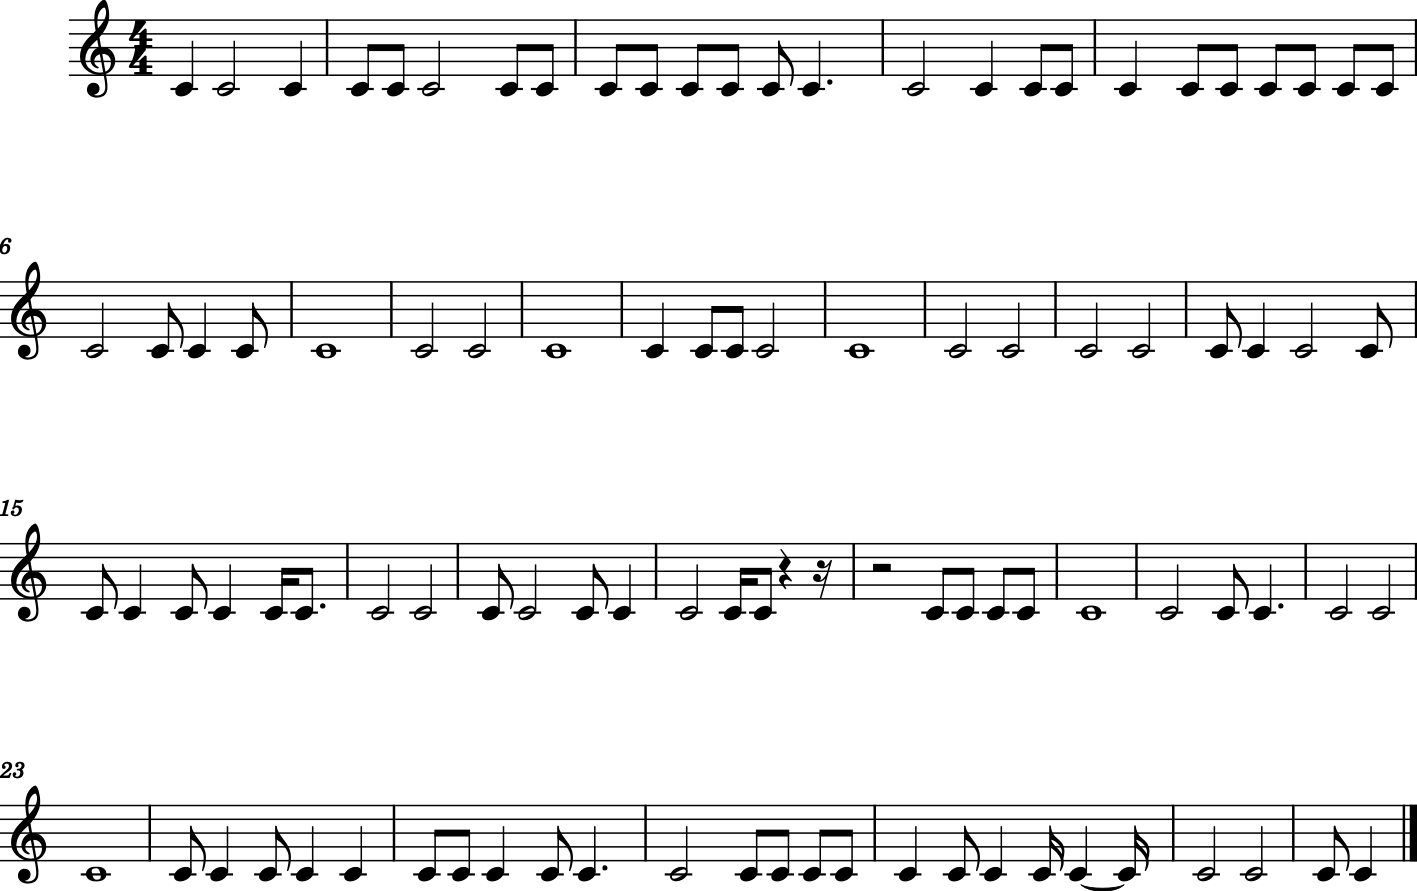

In [19]:
path = get_path(freq);
print (path)
path_rhythm = create_percussion(time_sig = '4/4')
print(path_rhythm)
path_rhythm = rhythm_from_sequence(path, rhythm=path_rhythm)
path_rhythm.show()
#play(path_rhythm)

# Music generation

## Bass Algorithm
##### This function will find the chords based on a scale and the bass note of the scale. The number of chords generated is dependent on the parameter chordsNbr. 

In [20]:
def getBassChords(_scale, _chordsNbr = 4, _octaveRegion = 2):
    
    bassChords = []; # stores Chord objects
    
    startBassNote = note.Note(pitch = _scale.baseNote.pitch.name, octave = _octaveRegion);
    
    bassChords.append(Chord(startBassNote, _scale));   # bassChords[0]

    #Generation of the chords based on a random algorithm 
    for i in range(_chordsNbr-1): 

        # Bass Rules
        nr = NotesRange();
        nr.addChanceToNotesWithoutOctave(_scale.getNotesWithoutOctave()); # notes of the scale

        if _scale.isMinor():
            nr.multiplyChanceToNotesWithoutOctave([_scale.getTone(2)], _probability = 0);
        if _scale.isMajor():
            nr.multiplyChanceToNotesWithoutOctave([_scale.getTone(7)], _probability = 0);

        nr.multiplyChanceToNotesWithoutOctave(bassChords[i].getNotesWithoutOctave(), _probability = 3); # notes of the chord from the bassNotes[i]
        nr.multiplyChanceToNotesWithoutOctave([bassChords[i].baseNote], _probability = 0); # playing the same bassNotes[i] again
        nr.multiplyByFunction(intervalFunction(6), note.Note(pitch = 6, octave = _octaveRegion)); # range, to stay in the octaveRegion

        bassChords.append(Chord(nr.pickRandomNote(), _scale)); #bassChords[i+1]
        
    return bassChords;

### Show bass
##### This function will create a score and two streams. The first two parameters will be inserted in the stream. The score is shown and played if the corresponding parameter is true.

In [21]:
def showBass(_bassChords, _bassNotes, _play = False):
       
    print("\nChords:")
    score = stream.Score()

    measureBassNotes = stream.Part();
    measureBassChords = stream.Part();

    score.insert(0, measureBassChords);
    score.insert(0, measureBassNotes);
     
    for i in range(len(_bassNotes)):
        print(i, _bassChords[i].getText(), _bassChords[i].getNotesWithoutOctave());  
        measureBassChords.append(_bassChords[i].getChordObject());
        measureBassNotes.append(_bassNotes[i]);

    score.show();
    if _play == True:
        play(score);

## MixMelodyChordsAndBass
##### The function bellow creates streams for the melody, the chords and the bass notes. Then we create a score to which we insert those streams. The streams will consist of the corresponding parameters. Furthermore we add a tempo and an option to play the score or not. 

In [22]:
def mixMelodyChordsAndBass(_melodyNotes, _bassChords, _bassNotes, _tempo = 60, _play = False):
    
    # Creation of the score
    score = stream.Score()
     
    # Creation of the streams    
    partMelodyNotes = stream.Part();
    partBassChords = stream.Part();
    partGuitarChords = stream.Part();
    partBassNotes = stream.Part();  
    
    # Definition of the tempo for the whole score
    partBassNotes.append(tempo.MetronomeMark(number = _tempo)); 
    
    # Insertion of the streams in the scores
    score.insert(0, partMelodyNotes); 
    score.insert(0, partBassChords);
    score.insert(0, partGuitarChords); 
    score.insert(0, partBassNotes);
      
    # Addition of the chords and bass notes to the streams
    for i in range(len(_bassNotes)):
        print(i, _bassChords[i].getText(), _bassChords[i].getNotesWithoutOctave());  
        
        _bassNotes[i].quarterLength = 4;
        partBassNotes.append(_bassNotes[i]);
        partBassChords.append(_bassChords[i].getChordObject(_quarterLength = 4));
        for k in range (0, 4):
            if k == 0 or k == 1 or k == 2:
                partGuitarChords.append(_bassChords[i].getChordObject(_quarterLength = 1));
            elif k == 3:
                partGuitarChords.append(_bassChords[i].getChordObject(_quarterLength = 1/2));
                partGuitarChords.append(_bassChords[i].getChordObject(_quarterLength = 1/2));        
    
    # Addition of notes from the melody to the corresponding stream
    for i in range(len(_melodyNotes)):
        partMelodyNotes.append(_melodyNotes[i]);
    
    # The score is shown and played if the boolean parameter
    score.show();
    if _play == True:
        play(score);
    
    return score;

## Melody with chords function
##### The following functions takes as parameteres a scale, a chrod and durations. The code in the cell is commented in order to understand the whole process.

In [23]:
def getMelody(_scale, _bassChords, _durations, _season):
        
    melodyNotes = [];
      
    measureCounter = 0;
    quarterLengthCounter = 0;
    
    # start note of the melody, a random note belonging to the first chord
    if _season == "spring":
        octave = 6
    elif _season == "summer":
        octave = 4
    elif _season == "autumn":
        octave = 4
    elif _season == "winter":
        octave = 3
        
    startNote = _bassChords[0].getNotesWithOctave(octave)[random.randint(0, len(_bassChords[0].getNotesWithoutOctave())-1)];

    # loop through the _durations
    for i in range(len(_durations)):
            
        # define dur
        dur = abs(_durations[i]);
                
        # Rest convention from the get_path() function
        isRest = dur < 1;
        if isRest:
            dur *= 4;
        else:
            dur /= 4;
                    
        # Actualize the counters
        quarterLengthCounter += dur;
        measureCounter = int(quarterLengthCounter/4-0.01);
        
        # Checks if arrived at the end of the _bassChords
        if measureCounter > len(_bassChords)-1:
            print("finished", measureCounter, len(_bassChords))
            break;
        
        # Rest
        if isRest:                            
            melodyNotes.append(note.Rest(quarterLength = dur));
               
        # Note
        else:                               
            # First note
            if i == 0:          
                melodyNotes.append(note.Note(pitch = startNote.pitch, quarterLength = dur));
            
            # Following notes
            else:       
                # Find previous melody note
                previousMelodyNote = note.Note();
                for u in range(len(melodyNotes)):
                    if type(melodyNotes[u]) is note.Note:
                        previousMelodyNote = melodyNotes[u];
                        break;
                    
                # Melody Rules
                nr = NotesRange();
                nr.addChanceToNotesWithoutOctave(_bassChords[measureCounter].getNotesWithoutOctave());
                nr.multiplyByFunction(intervalFunction(6), previousMelodyNote); # to stay close to the previous note
                nr.multiplyByFunction(gaussFunction(12), startNote); # to stay at the melody "height"
                
                # Pick next melody note
                n = nr.pickRandomNote();
                n.quarterLength = dur;
                melodyNotes.append(n)
                
                print("chose Note", n.pitch, "chord", _bassChords[measureCounter].getText());
    
    return melodyNotes;

##### The function below converts notes into a stream.

In [24]:
def getStreamFromNotes(_notes):
    s = stream.Stream();
    s.timeSignature = meter.TimeSignature('4/4');
    s.append(_notes);
    return s;

# The music generator

### Scale
##### In the following cell a random scale will be generated using the scale constructor. Therefore every time the cell is run a new scale will be generated.

G# major [0, 2, 4, 5, 7, 9, 11]


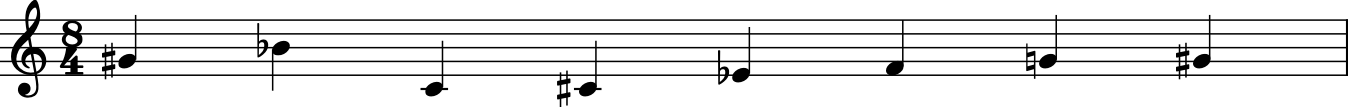

In [25]:
theScale = Scale(_randomBase = True, _randomMinorMajorScale = True);
theScale.show();

### Bass
##### In the following cell, we create a score with a scale and chords.


Chords:
0 G#  [<music21.note.Note G#>, <music21.note.Note C>, <music21.note.Note E->]
1 C m [<music21.note.Note C>, <music21.note.Note E->, <music21.note.Note G>]
2 F m [<music21.note.Note F>, <music21.note.Note G#>, <music21.note.Note C>]
3 E-  [<music21.note.Note E->, <music21.note.Note G>, <music21.note.Note B->]
4 G#  [<music21.note.Note G#>, <music21.note.Note C>, <music21.note.Note E->]
5 C m [<music21.note.Note C>, <music21.note.Note E->, <music21.note.Note G>]
6 F m [<music21.note.Note F>, <music21.note.Note G#>, <music21.note.Note C>]
7 E-  [<music21.note.Note E->, <music21.note.Note G>, <music21.note.Note B->]


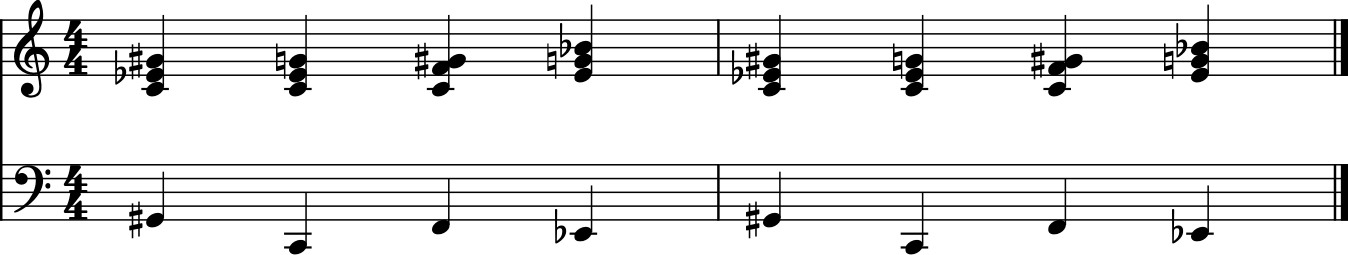

In [26]:
theOctaveRegion = 2;
theChordsNbr = 4;

theBassChords = getBassChords(theScale, theChordsNbr, theOctaveRegion);
for i in range(len(theBassChords)):
    theBassChords.append(theBassChords[i].copy());

theBassNotes = [note.Note(pitch = c.baseNote.pitch.name, octave = theOctaveRegion) for c in theBassChords];

showBass(theBassChords, theBassNotes, _play = True);

### Melody
##### In the following cell we will mix the generated rythme and the generated sequence of notes.

theDurations [4, 2, 2, 8, 0.125, 2, 2, 8, 2.0, 4, 4, 8, 4, 2, 8, 2.0, 4, 2, 0.125, 4, 2, 2.0, 4, 8, 4.0, 8, 8, 8, 2, 6.0, 8, 0.125, 6.0, 16, 0.125, 14.0, 16, 0.125, 4, 4, 4, 2.0, 16, 8, 4, 4.0, 8, 4, 4.0, 16, 2, 2, 8, 2, 2.0, 8, 4, 4, 2, 4, 4, 2, 4.0, 8, 8, 2, 4, 1, 8, 1.0, 4, 8, 4, 4, 2, 2, 2, 4, 1, 1.0, 8, 4, 4, 4, 8, 4.0, 8, 0.125, 6.0, 16, 2, 14.0, 16, 1, 2, 4, 4, 4, 1.0, 4, 2, 2, 8, 4, 4, 8, 16, 2, 14.0, 16, 4, 4, 0.125, 4, 2.0, 16, 4, 2, 2, 0.125, 4, 2.0, 4, 4, 4, 2, 2.0, 16, 16, 8, 8, 4, 4, 1, 7.0, 8, 4, 4.0, 16, 4, 4, 4, 2, 1, 1.0, 16, 2, 2, 4, 1, 7.0, 16, 2, 14.0, 16, 4, 4, 8.0, 16, 2, 4, 8, 2.0, 4, 8, 2, 2, 8, 1, 4, 2, 1.0, 2, 14.0, 16, 4, 2, 0.125, 8.0, 16, 16, 1, 4, 11.0, 16, 4, 1, 4, 2, 5.0, 8, 2, 6.0, 16, 4, 1, 2, 4, 0.25, 1.0, 8, 2, 4, 2.0, 8, 4, 2, 2.0, 4, 8, 4, 2, 8, 2, 4.0, 8, 4, 4, 1, 8, 2, 4, 1.0, 8, 4, 0.125, 2.0, 4, 1, 11.0, 16, 2, 14.0, 16, 16, 4, 2, 4, 4, 2, 16, 16, 2, 2, 12.0, 16, 2, 2, 8, 2, 2, 2, 4, 4, 4, 2.0, 8, 2, 6.0, 16, 8, 8, 2, 8, 2, 2, 2, 2, 4, 4, 6.0,

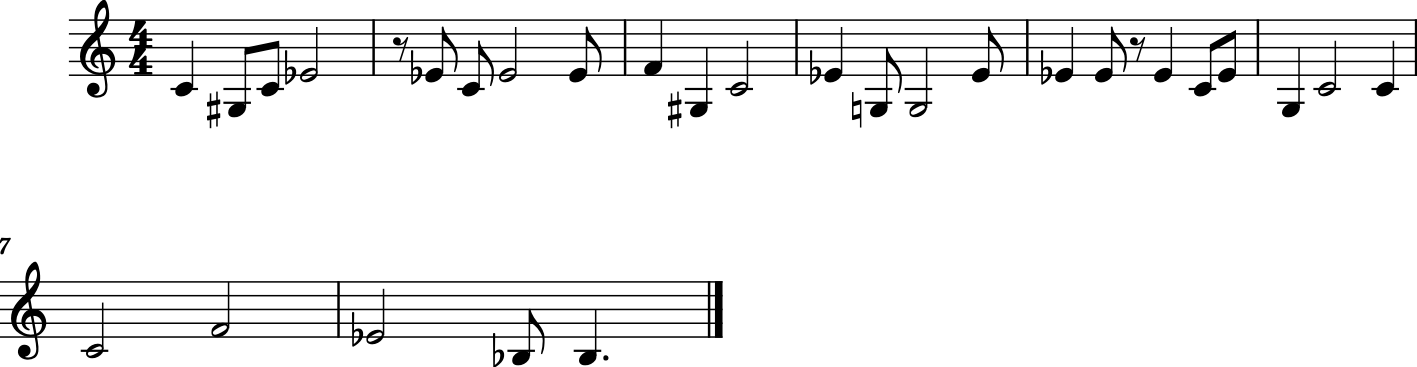

In [27]:
theDurations = get_path(freq);

print("theDurations",theDurations);
theMelody = getMelody(theScale, theBassChords, theDurations, "summer")

melodyStream = getStreamFromNotes(theMelody);
melodyStream.show();

### Mix melody and chords
##### In the following cell we will mix the melody and the chords in order to create a 4 staff piece.

0 G#  [<music21.note.Note G#>, <music21.note.Note C>, <music21.note.Note E->]
1 C m [<music21.note.Note C>, <music21.note.Note E->, <music21.note.Note G>]
2 F m [<music21.note.Note F>, <music21.note.Note G#>, <music21.note.Note C>]
3 E-  [<music21.note.Note E->, <music21.note.Note G>, <music21.note.Note B->]
4 G#  [<music21.note.Note G#>, <music21.note.Note C>, <music21.note.Note E->]
5 C m [<music21.note.Note C>, <music21.note.Note E->, <music21.note.Note G>]
6 F m [<music21.note.Note F>, <music21.note.Note G#>, <music21.note.Note C>]
7 E-  [<music21.note.Note E->, <music21.note.Note G>, <music21.note.Note B->]


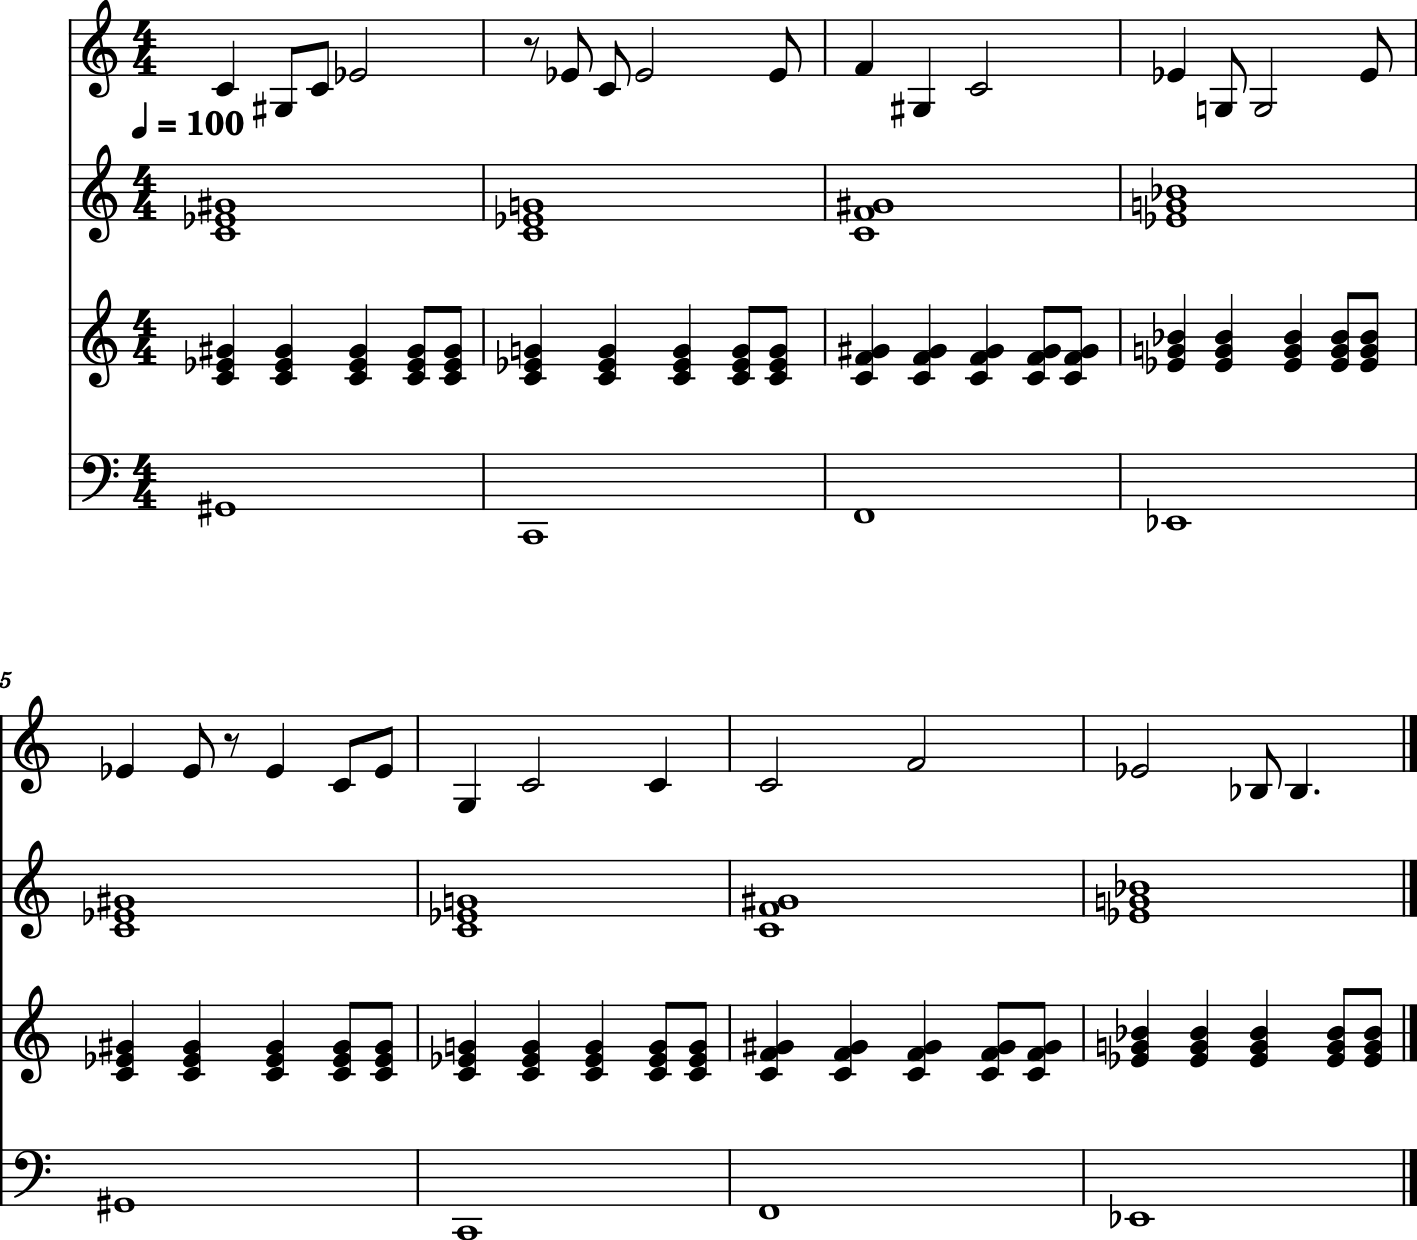

In [28]:
bpm = 100;
theScore = mixMelodyChordsAndBass(theMelody, theBassChords, theBassNotes, bpm, True);

### Instruments
##### In the following cell, the instruments were changed. The top staff of the score will be played by the violin, the second one by the contrabass, the third by the guitar and the last one by the piano. Furthermore we decided to play the second and fourth staffs a little quieter than the others. 

In [29]:
theScore[0].insert(0, instrument.Violin())
theScore[1].insert(0, instrument.Contrabass())
theScore[2].insert(0, instrument.Guitar())
theScore[1].insert(0, dynamics.Dynamic(0.3))
theScore[3].insert(0, dynamics.Dynamic(1))
theScore[3].insert(0, dynamics.Dynamic(0.8))

play(theScore)

# The piece
##### The piece itself will be composed of 4 mouvements representing the 4 seasons. Each movement is characterised by its instruments, its partition and a sound that we will add on top of the aleatoricly generated piece. Furthermore we will make sure that each movement has specificities that represent the respective season. For example, we will try to compose a more slow and heavy sound for the winter. This specific assembly will be done in future steps of our project.

## Modified audio sample
##### These audio samples have been taken from youtube and modified on Audacity to get rid of background noise. We will show you an example of how we have managed to this and try to insert the audio before and after the modification.

#### How to get rid of background noise
##### The steps to get rid of the backgroud noise are the following. First what we can see on the image below is that the bottom two lines represent the same audio sample as the bottom two except they don't contain any background noises anymore. Therefore we will show the steps of how to recreate the top two lines while starting with the bottom two lines.

![](Pic1.png)

##### To start zoom in on a section with only background noise and select as long of a segment as possible. As you can see the lighter segment has been selected.

![](Pic2.png)

##### Now go onto 'Effect' and select 'Raush-Verminderung' ('Noise Reduction')

![](Pic3.png)

##### You will see the following window poping up. Try to manipulate the three number ('Rausch-Verminderung (dB)', 'Empfinldichkeit' and 'Frequenz-Glättung (Bänder)') in order to get rid of your background noise. Everytime you change these numbers press 'Vorhören' in order to listen to you selected sequence with those changes. Once you are satisfied with the result press 'OK'

![](Pic4.png)

##### You can now see that all the background noise from the selected area has disappreared. 

![](Pic5.png)

##### Now select the whole audio sample and go back onto 'Effect' and select 'Rausch-Verminderung wiederholen'. This step will apply the background noise cancelling previously formated to the whole audio sample.

![](Pic6.png)

##### As we can see now we have achieved our goal. All four lanes look the same.

![](Pic7.png)

#### How to change the pitch 
##### Select the part of the audio that you want to change the pitch of. Then go search for 'Change Pitch' (or 'Tonhöhe ändern' in the previous pictures) under the 'Effect' bar. And decide which pitch you would like.

#### Examples
##### BirdOriginal is the original sound taken from youtube before we modified it and got rid of the background noise. As you can hear there is a lot of background noise in this audio sample. The second one (Bird.wav) is the sample we got after doing all the steps mentionned previously. As you can hear there is hardly anymore background noise. The third audio sample (bird2.wav) is the same as the second one except it is in a different pitch. As you can hear it the birds seem to have a lower pitch in the thirs audio sample.
##### Remarque : other audio files will be used in the making of our final piece however as the files are quite big it would not be possible to upload them on the moodle page.

In [30]:
Audio('BirdOriginal.mp3')

In [31]:
Audio('Bird.mp3')

In [32]:
Audio('bird2.mp3')

## Spring

##### Here we have already tried to write a score for the Spring. During the spring, the instruments being played are the piano the guitar, and the piccolo. We also chose some frequencies for the rythme that would match a spring like atmosphere. The scale chosen here is E major as it is this one that Vivaldi chose for his spring movement himself.

E major [0, 2, 4, 5, 7, 9, 11]


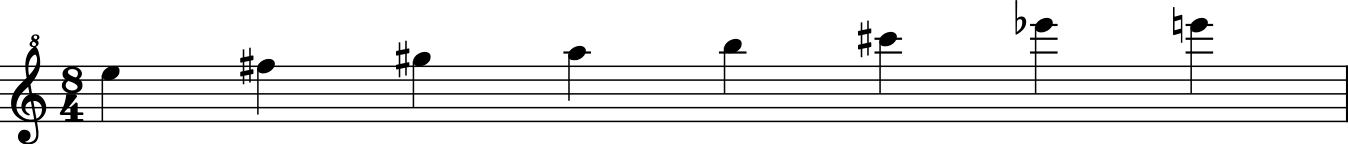


Chords:
0 E  [<music21.note.Note E>, <music21.note.Note G#>, <music21.note.Note B>]
1 G# m [<music21.note.Note G#>, <music21.note.Note B>, <music21.note.Note E->]
2 F# m [<music21.note.Note F#>, <music21.note.Note A>, <music21.note.Note C#>]
3 C# m [<music21.note.Note C#>, <music21.note.Note E>, <music21.note.Note G#>]
4 E  [<music21.note.Note E>, <music21.note.Note G#>, <music21.note.Note B>]
5 G# m [<music21.note.Note G#>, <music21.note.Note B>, <music21.note.Note E->]
6 F# m [<music21.note.Note F#>, <music21.note.Note A>, <music21.note.Note C#>]
7 C# m [<music21.note.Note C#>, <music21.note.Note E>, <music21.note.Note G#>]


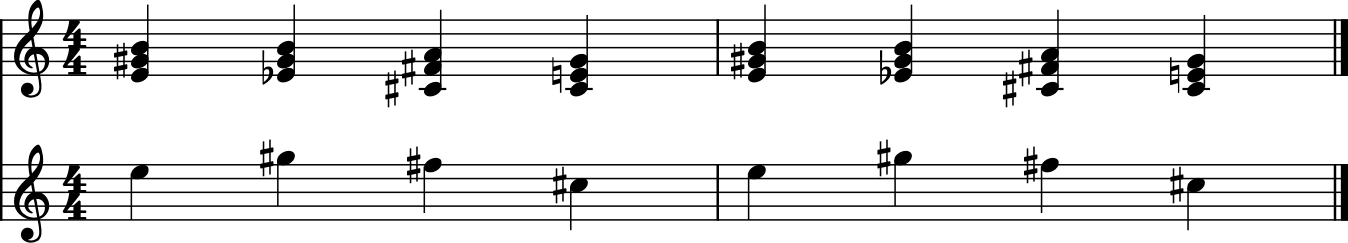

chose Note G#6 chord E 
chose Note G#6 chord E 
chose Note B6 chord E 
chose Note B6 chord G# m
chose Note E-6 chord G# m
chose Note G#6 chord G# m
chose Note B6 chord G# m
chose Note A6 chord F# m
chose Note F#6 chord F# m
chose Note E6 chord C# m
chose Note C#7 chord C# m
chose Note C#7 chord C# m
chose Note E6 chord E 
chose Note B6 chord G# m
chose Note B6 chord G# m
chose Note F#6 chord F# m
chose Note A6 chord F# m
chose Note C#7 chord F# m
chose Note F#6 chord F# m
chose Note G#6 chord C# m
chose Note E6 chord C# m
chose Note E6 chord C# m
chose Note G#6 chord C# m
chose Note G#6 chord C# m
chose Note G#6 chord C# m
finished 8 8
chose Note B5 chord E 
chose Note B5 chord E 
chose Note E6 chord E 
chose Note G#6 chord G# m
chose Note G#6 chord G# m
chose Note G#6 chord G# m
chose Note E-6 chord G# m
chose Note C#6 chord F# m
chose Note A6 chord F# m
chose Note G#6 chord C# m
chose Note E6 chord C# m
chose Note G#6 chord C# m
chose Note B5 chord E 
chose Note G#6 chord G# m
chose 

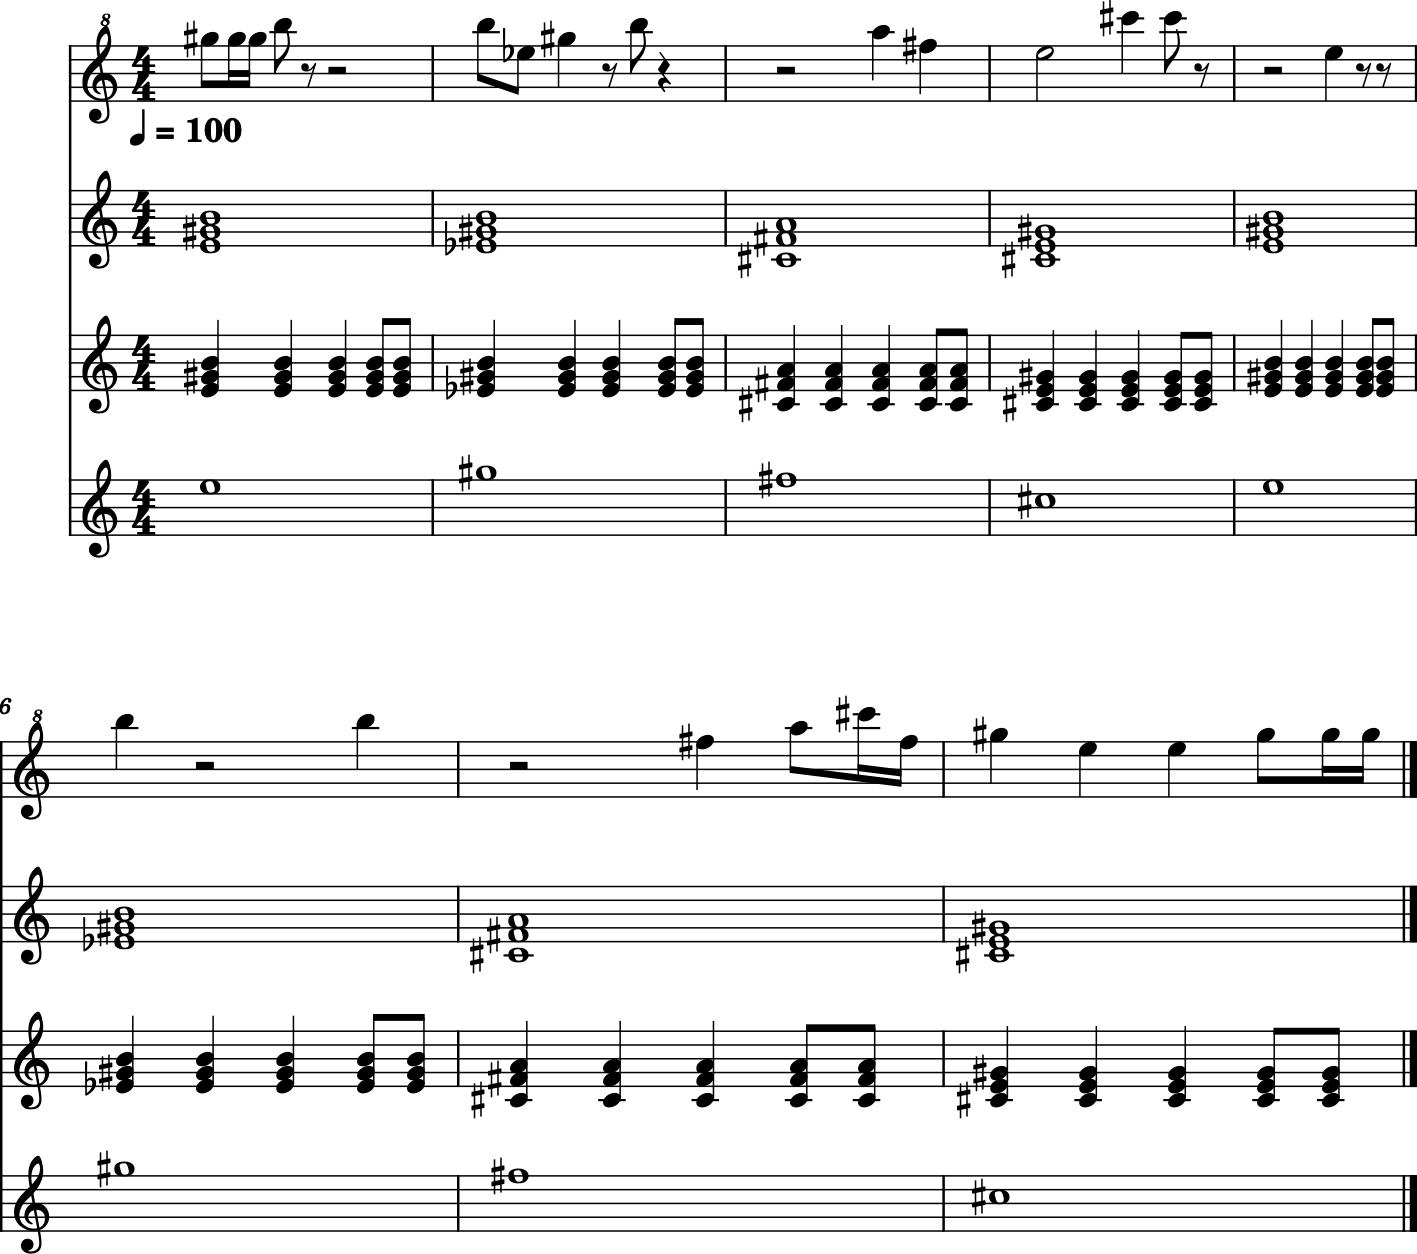

In [33]:
baseNoteSpring = note.Note('E6')
intervalSpring = scalesIntervalDictionnary["major"]
springScale = Scale (baseNoteSpring, intervalSpring)
springScale.show()
springChord = Chord(baseNoteSpring, springScale);
springFreq = [10, 30, 30, 10, 5, 3, 2, 1]

springOctaveRegion = 5
springChordsNumber = 4
springBassChords = getBassChords(springScale, springChordsNumber, springOctaveRegion);

for i in range(len(springBassChords)):
    springBassChords.append(springBassChords[i].copy());

springBassNotes = [note.Note(pitch = c.baseNote.pitch.name, octave = springOctaveRegion) for c in springBassChords];

showBass(springBassChords, springBassNotes, _play = False)

springDurations = get_path(springFreq)
springMelody = getMelody (springScale, springBassChords, springDurations, "spring")

springMelodyStream = getMelody(springScale, springBassChords, springDurations, "spring")

springBPM = 100
springScore = mixMelodyChordsAndBass(springMelody, springBassChords, springBassNotes, springBPM, False)

springScore[0].insert(0, instrument.Flute())
springScore[1].insert(0, instrument.Piano())
springScore[2].insert(0, instrument.Guitar())
springScore[3].insert(0, instrument.Piano())

springScore[0].insert(0, dynamics.Dynamic(1))
springScore[1].insert(0, dynamics.Dynamic(0.5))
springScore[2].insert(0, dynamics.Dynamic(0.5))
springScore[3].insert(0, dynamics.Dynamic(0.5))

In [34]:
play(springScore)

## Summer

In [35]:
# instruments : piano, percussion, guitar ???
# scale:G minor

G minor [0, 2, 3, 5, 7, 8, 10]


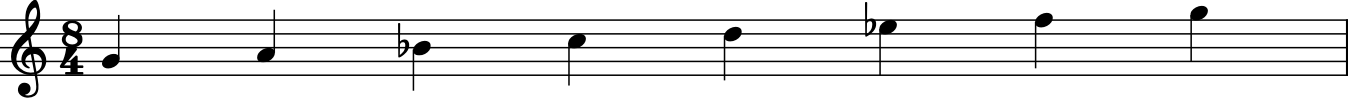

In [36]:
baseNoteSummer = note.Note('G4')
intervalSummer = scalesIntervalDictionnary["minor"]
summerScale = Scale(baseNoteSummer, intervalSummer)
summerScale.show()

## Autumn

In [37]:
# instruments : piano, percussion, guitar, violin
# scale: F major

F major [0, 2, 4, 5, 7, 9, 11]


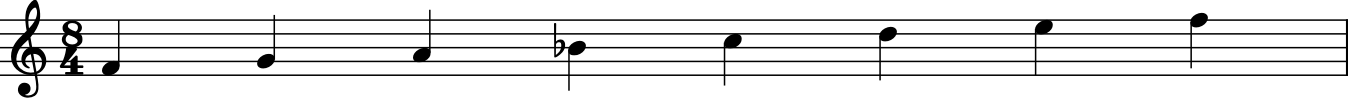

In [38]:
baseNoteAutumn = note.Note('F4')
intervalAutumn = scalesIntervalDictionnary["major"]
autumnScale = Scale(baseNoteAutumn, intervalAutumn)
autumnScale.show()

## Winter

In [39]:
# instruments : piano, percussion, guitar, counterbasson
# scale:F minor

F major [0, 2, 4, 5, 7, 9, 11]


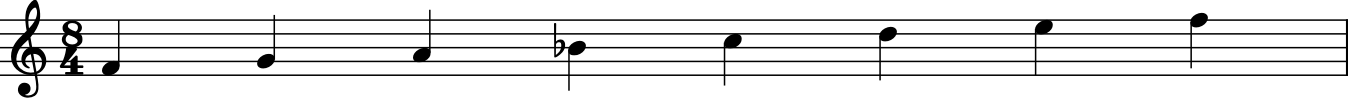

In [40]:
baseNoteWinter = note.Note('F4')
intervalWinter = scalesIntervalDictionnary["major"]
winterScale = Scale(baseNoteWinter, intervalWinter)
winterScale.show()